In [215]:
!pip install rasterio


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [216]:
LR = 5e-4
EPOCHS = 100
EPOCHS_PER_UPDATE = 1
RUNNAME = "Sen1Floods11"
S1 = "v1.1/data/flood_events/HandLabeled/S1Hand/"
LABELS = "v1.1/data/flood_events/HandLabeled/LabelHand/"

In [217]:
import torch
from torchvision import transforms
import torchvision.transforms.functional as F
import random
from PIL import Image

class InMemoryDataset(torch.utils.data.Dataset):
  
  def __init__(self, data_list, preprocess_func):
    self.data_list = data_list
    self.preprocess_func = preprocess_func
  
  def __getitem__(self, i):
    return self.preprocess_func(self.data_list[i])
  
  def __len__(self):
    return len(self.data_list)


def processAndAugment(data):
  (x,y) = data
  im,label = x.copy(), y.copy()

  # convert to PIL for easier transforms
  im1 = Image.fromarray(im[0])
  im2 = Image.fromarray(im[1])
  label = Image.fromarray(label.squeeze())

  # Get params for random transforms
  i, j, h, w = transforms.RandomCrop.get_params(im1, (256, 256))
  
  im1 = F.crop(im1, i, j, h, w)
  im2 = F.crop(im2, i, j, h, w)
  label = F.crop(label, i, j, h, w)
  if random.random() > 0.5:
    im1 = F.hflip(im1)
    im2 = F.hflip(im2)
    label = F.hflip(label)
  if random.random() > 0.5:
    im1 = F.vflip(im1)
    im2 = F.vflip(im2)
    label = F.vflip(label)
  
  norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])
  im = torch.stack([transforms.ToTensor()(im1).squeeze(), transforms.ToTensor()(im2).squeeze()])
  im = norm(im)
  label = transforms.ToTensor()(label).squeeze()
  if torch.sum(label.gt(.003) * label.lt(.004)):
    label *= 255
  label = label.round()

  return im, label


def processTestIm(data):
  (x,y) = data
  im,label = x.copy(), y.copy()
  norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])

  # convert to PIL for easier transforms
  im_c1 = Image.fromarray(im[0]).resize((512,512))
  im_c2 = Image.fromarray(im[1]).resize((512,512))
  label = Image.fromarray(label.squeeze()).resize((512,512))

  im_c1s = [F.crop(im_c1, 0, 0, 256, 256), F.crop(im_c1, 0, 256, 256, 256),
            F.crop(im_c1, 256, 0, 256, 256), F.crop(im_c1, 256, 256, 256, 256)]
  im_c2s = [F.crop(im_c2, 0, 0, 256, 256), F.crop(im_c2, 0, 256, 256, 256),
            F.crop(im_c2, 256, 0, 256, 256), F.crop(im_c2, 256, 256, 256, 256)]
  labels = [F.crop(label, 0, 0, 256, 256), F.crop(label, 0, 256, 256, 256),
            F.crop(label, 256, 0, 256, 256), F.crop(label, 256, 256, 256, 256)]

  ims = [torch.stack((transforms.ToTensor()(x).squeeze(),
                    transforms.ToTensor()(y).squeeze()))
                    for (x,y) in zip(im_c1s, im_c2s)]
  
  ims = [norm(im) for im in ims]
  ims = torch.stack(ims)
  
  labels = [(transforms.ToTensor()(label).squeeze()) for label in labels]
  labels = torch.stack(labels)
  
  if torch.sum(labels.gt(.003) * labels.lt(.004)):
    labels *= 255
  labels = labels.round()
  
  return ims, labels

In [218]:
from time import time
import csv
import os
import numpy as np
import rasterio

def getArrFlood(fname):
  return rasterio.open(fname).read()

def download_flood_water_data_from_list(l):
  i = 0
  tot_nan = 0
  tot_good = 0
  flood_data = []
  for (im_fname, mask_fname) in l:
    if not os.path.exists(im_fname):
      continue
    arr_x = np.nan_to_num(getArrFlood(im_fname))
    arr_y = getArrFlood(mask_fname)
    arr_y[arr_y == -1] = 255 
    
    arr_x = np.clip(arr_x, -50, 1)
    arr_x = (arr_x + 50) / 51
      
    if i % 100 == 0:
      print(im_fname, mask_fname)
    i += 1
    flood_data.append((arr_x,arr_y))

  return flood_data

def load_flood_train_data(input_root, label_root):
  fname = "flood_train_data.csv"
  training_files = []
  with open(fname) as f:
    for line in csv.reader(f):
      training_files.append(tuple((input_root+line[0], label_root+line[1])))

  return download_flood_water_data_from_list(training_files)

def load_flood_valid_data(input_root, label_root):
  fname = "flood_valid_data.csv"
  validation_files = []
  with open(fname) as f:
    for line in csv.reader(f):
      validation_files.append(tuple((input_root+line[0], label_root+line[1])))

  return download_flood_water_data_from_list(validation_files)

def load_flood_test_data(input_root, label_root):
  fname = "flood_test_data.csv"
  testing_files = []
  with open(fname) as f:
    for line in csv.reader(f):
      testing_files.append(tuple((input_root+line[0], label_root+line[1])))
  
  return download_flood_water_data_from_list(testing_files)

In [220]:
train_data = load_flood_train_data(S1, LABELS)
train_dataset = InMemoryDataset(train_data, processAndAugment)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0, collate_fn=None,
                  pin_memory=True, drop_last=False, timeout=0,
                  worker_init_fn=None)
train_iter = iter(train_loader)

valid_data = load_flood_valid_data(S1, LABELS) 
valid_dataset = InMemoryDataset(valid_data, processTestIm)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0, collate_fn=lambda x: (torch.cat([a[0] for a in x], 0), torch.cat([a[1] for a in x], 0)),
                  pin_memory=True, drop_last=False, timeout=0,
                  worker_init_fn=None)
valid_iter = iter(valid_loader)

v1.1/data/flood_events/HandLabeled/S1Hand/Ghana_103272_S1Hand.tif v1.1/data/flood_events/HandLabeled/LabelHand/Ghana_103272_LabelHand.tif
v1.1/data/flood_events/HandLabeled/S1Hand/Pakistan_132143_S1Hand.tif v1.1/data/flood_events/HandLabeled/LabelHand/Pakistan_132143_LabelHand.tif
v1.1/data/flood_events/HandLabeled/S1Hand/Sri-Lanka_916628_S1Hand.tif v1.1/data/flood_events/HandLabeled/LabelHand/Sri-Lanka_916628_LabelHand.tif
v1.1/data/flood_events/HandLabeled/S1Hand/Ghana_5079_S1Hand.tif v1.1/data/flood_events/HandLabeled/LabelHand/Ghana_5079_LabelHand.tif


In [221]:
import torch
import torch.nn as nn
import torch.nn.functional as TF

class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        
        # Encoder
        self.enc1 = nn.Conv2d(2, 64, kernel_size=3, padding=1)  
        self.enc2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Max-pooling layer for down-sampling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Decoder
        self.dec1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = nn.Conv2d(64, 2, kernel_size=3, padding=1)  
        
    def forward(self, x):
        # Encoder path
        x1 = TF.relu(self.enc1(x))
        x2 = TF.relu(self.enc2(self.pool(x1)))
        x3 = TF.relu(self.enc3(self.pool(x2)))

        # Decoder path
        x = TF.relu(self.dec1(x3))
        x = TF.relu(self.dec2(x))
        x = self.dec3(x)  

        return x

criterion = nn.CrossEntropyLoss(weight=torch.tensor([1,8]).float(), ignore_index=255) 
optimizer = torch.optim.AdamW(net.parameters(),lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, len(train_loader) * 10, T_mult=2, eta_min=0, last_epoch=-1)

# Testing the model
net = SimpleUNet()
sample_input = torch.randn(16, 2, 256, 256)  
output = net(sample_input)

print("Output shape:", output.shape)  

Output shape: torch.Size([16, 2, 256, 256])


In [222]:
def computeIOU(output, target):
  output = torch.argmax(output, dim=1).flatten() 
  target = target.flatten()
  
  no_ignore = target.ne(255)
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  intersection = torch.sum(output * target)
  union = torch.sum(target) + torch.sum(output) - intersection
  iou = (intersection + .0000001) / (union + .0000001)
  
  if iou != iou:
    print("failed, replacing with 0")
    iou = torch.tensor(0).float()
  
  return iou
  
def computeAccuracy(output, target):
  output = torch.argmax(output, dim=1).flatten() 
  target = target.flatten()
  
  no_ignore = target.ne(255)
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  correct = torch.sum(output.eq(target))
  
  return correct.float() / len(target)

def truePositives(output, target):
  output = torch.argmax(output, dim=1).flatten() 
  target = target.flatten()
  no_ignore = target.ne(255)
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  correct = torch.sum(output * target)
  
  return correct

def trueNegatives(output, target):
  output = torch.argmax(output, dim=1).flatten() 
  target = target.flatten()
  no_ignore = target.ne(255)
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  output = (output == 0)
  target = (target == 0)
  correct = torch.sum(output * target)
  
  return correct

def falsePositives(output, target):
  output = torch.argmax(output, dim=1).flatten() 
  target = target.flatten()
  no_ignore = target.ne(255)
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  output = (output == 1)
  target = (target == 0)
  correct = torch.sum(output * target)
  
  return correct

def falseNegatives(output, target):
  output = torch.argmax(output, dim=1).flatten() 
  target = target.flatten()
  no_ignore = target.ne(255)
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  output = (output == 0)
  target = (target == 1)
  correct = torch.sum(output * target)
  
  return correct

In [223]:
training_losses = []
training_accuracies = []
training_ious = []

def train_loop(inputs, labels, net, optimizer, scheduler):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  
  # zero the parameter gradients
  optimizer.zero_grad()
  # net = net.cuda()
  
  # forward + backward + optimize
  outputs = net(inputs)
  loss = criterion(outputs, labels.long())
  loss.backward()
  optimizer.step()
  scheduler.step()

  running_loss += loss
  running_iou += computeIOU(outputs, labels)
  running_accuracy += computeAccuracy(outputs, labels)
  running_count += 1

In [224]:
valid_losses = []
valid_accuracies = []
valid_ious = []

def validation_loop(validation_data_loader, net):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  global max_valid_iou

  global training_losses
  global training_accuracies
  global training_ious
  global valid_losses
  global valid_accuracies
  global valid_ious

  net = net.eval()
  # net = net.cuda()
  count = 0
  iou = 0
  loss = 0
  accuracy = 0
  with torch.no_grad():
      for (images, labels) in validation_data_loader:
          # net = net.cuda()
          outputs = net(images)
          valid_loss = criterion(outputs, labels.long())
          valid_iou = computeIOU(outputs, labels)
          valid_accuracy = computeAccuracy(outputs, labels)
          iou += valid_iou
          loss += valid_loss
          accuracy += valid_accuracy
          count += 1

  iou = iou / count
  accuracy = accuracy / count

  if iou > max_valid_iou:
    max_valid_iou = iou
    save_path = os.path.join("checkpoints", "{}_{}_{}.cp".format(RUNNAME, i, iou.item()))
    torch.save(net.state_dict(), save_path)
    print("model saved at", save_path)

  loss = loss / count
  print("Training Loss:", running_loss / running_count)
  print("Training IOU:", running_iou / running_count)
  print("Training Accuracy:", running_accuracy / running_count)
  print("Validation Loss:", loss)
  print("Validation IOU:", iou)
  print("Validation Accuracy:", accuracy)


  training_losses.append(running_loss / running_count)
  training_accuracies.append(running_accuracy / running_count)
  training_ious.append(running_iou / running_count)
  valid_losses.append(loss)
  valid_accuracies.append(accuracy)
  valid_ious.append(iou)

In [225]:
def test_loop(test_data_loader, net):
  net = net.eval()
  # net = net.cuda()
  count = 0
  iou = 0
  loss = 0
  accuracy = 0
  with torch.no_grad():
      for (images, labels) in tqdm(test_data_loader):
          # net = net.cuda()
          outputs = net(images)
          valid_loss = criterion(outputs, labels.long())
          valid_iou = computeIOU(outputs, labels)
          iou += valid_iou
          accuracy += computeAccuracy(outputs, labels)
          count += 1

  iou = iou / count
  print("Test IOU:", iou)
  print("Test Accuracy:", accuracy / count)

In [226]:
from tqdm.notebook import tqdm
from IPython.display import clear_output

running_loss = 0
running_iou = 0
running_count = 0
running_accuracy = 0

training_losses = []
training_accuracies = []
training_ious = []
valid_losses = []
valid_accuracies = []
valid_ious = []


def train_epoch(net, optimizer, scheduler, train_iter):
  i = 0
  for (inputs, labels) in tqdm(train_iter):
    train_loop(inputs, labels, net, optimizer, scheduler)
 

def train_validation_loop(net, optimizer, scheduler, train_loader,
                          valid_loader, num_epochs, cur_epoch):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  net = net.train()
  running_loss = 0
  running_iou = 0
  running_count = 0
  running_accuracy = 0
  
  for i in tqdm(range(num_epochs)):
    train_iter = iter(train_loader)
    train_epoch(net, optimizer, scheduler, train_iter)
  clear_output()
  
  print("Current Epoch:", cur_epoch)
  validation_loop(iter(valid_loader), net)

Current Epoch: 4
Training Loss: tensor(0.6923, grad_fn=<DivBackward0>)
Training IOU: tensor(0.0694)
Training Accuracy: tensor(0.8660)
Validation Loss: tensor(0.6923)
Validation IOU: tensor(0.0748)
Validation Accuracy: tensor(0.8539)


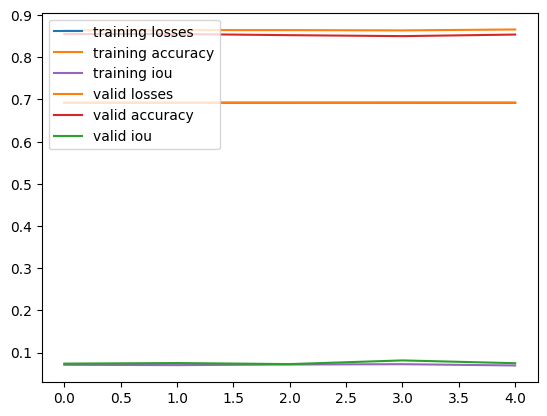

None

max valid iou: tensor(0.0814)


In [227]:
import os
from IPython.display import display
import matplotlib.pyplot as plt
import torch # Importing torch

max_valid_iou = 0
start = 0

epochs = []
training_losses = []
training_accuracies = []
training_ious = []
valid_losses = []
valid_accuracies = []
valid_ious = []

for i in range(start, 5):
  train_validation_loop(net, optimizer, scheduler, train_loader, valid_loader, 10, i)
  epochs.append(i)
  x = epochs
  # Detach tensors from the computation graph before converting to NumPy arrays
  plt.plot(x, [t.cpu().detach().numpy() for t in training_losses], label='training losses') 
  plt.plot(x, [t.cpu().detach().numpy() for t in training_accuracies], 'tab:orange', label='training accuracy')
  plt.plot(x, [t.cpu().detach().numpy() for t in training_ious], 'tab:purple', label='training iou')
  plt.plot(x, [t.cpu().detach().numpy() for t in valid_losses], label='valid losses')
  plt.plot(x, [t.cpu().detach().numpy() for t in valid_accuracies], 'tab:red',label='valid accuracy')
  plt.plot(x, [t.cpu().detach().numpy() for t in valid_ious], 'tab:green',label='valid iou')
  plt.legend(loc="upper left")

  display(plt.show())

  print("max valid iou:", max_valid_iou)

In [228]:
training_losses

[tensor(0.6923, grad_fn=<DivBackward0>),
 tensor(0.6923, grad_fn=<DivBackward0>),
 tensor(0.6924, grad_fn=<DivBackward0>),
 tensor(0.6924, grad_fn=<DivBackward0>),
 tensor(0.6923, grad_fn=<DivBackward0>)]